# Processing local field potentials (LFP)

This tutorial covers the generation of LFP signal from SpikeGLX recording files, loading the LFP data, and visualizing it. 

In [1]:
import os
import sys
# add the path to the parent directory to augment search for module
sys.path.append('../code/') # for relative import in jupyter notebook
import numpy as np
import matplotlib.pyplot as plt
from preprocess.lfp import make_lfp_file_spikeglx

## Calculate the LFP and save as binary file

Our Neuropixel 2.0 recording system is not configured to produce LFP recording files. Instead, it save wideband recordings as a binary file ending in '.ap.bin'. We want to extract the LFP from that file and save it as a new binary file. The function `make_lfp_file_spikeglx` does this. To use it, just call it while passing the string with the full file path to the wideband binary file. A progress bar should pop up while the LFP is extracted. Don't be suprised if it takes several hours. 

In [2]:
# binary data to load
bin_path = os.path.join("D:","SortingTest","24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1", 
                       "24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_imec0", 
                       "24-04-09_DH12_M1-Shk1_M2-SupraLayer_g1_t0.imec0.ap.bin")

# read meta file
lfp_path = make_lfp_file_spikeglx(bin_path) #read_meta(meta_path)

100%|██████████| 294/294 [4:46:35<00:00, 58.49s/it]  


## Low-level loading of the LFP binary
To load the LFP data, you can use the numpy `fromfile` function. (Note, everything we cover here also applies to the wideband '.ap.bin' file. Indeed, the `make_lfp_file_spikeglx` function does this) It requires passing the file path or object. However, if you want to access specific time periods or channels you have to know how the data is organized. In the binary file all data is stored as one long list of numbers. Each number is referred to as a sample. They are ordered first by channels, and then by time. If sample $V_{c,t}$ is the voltage on channel $c$ (there are $n$ channels) and time $t$, then the samples are stored in order $V_{0,0}, V_{1,0}, V_{2,0}, ..., V_{n,0}, V_{0,1}, V_{1,1}, V_{2,1}, ...$. Thus, to start accessing the data at a specific time index, $p$, you have to multiply it by the number of channels, $n \times p$. This is easy to do by setting the `offset` parameter in `fromfile`. To get just a single channel across multiple times points, you could try calling `fromfile` multiple times, each time taking just one sample (`count=1`), and setting your offset to $p+i$, where $i$ is the channel number (indexed from 0). This is highly inefficient because you have to make multiple read calls to the file, each with overhead. Instead, it is often faster to just read in all the channels across the time points you want to sample, reshape the array to have time along one axis and channels along the other, and then keep only the channel you care about. That is what we will demonstrate below.

In [40]:
# assuming we have 385 channels, let's determine the offsets that we need to read
# a 1 second epoch at the start of every minute of the recording.
n_channels = 385
n_samples = os.path.getsize(lfp_path)//2 # number of samples in the LFP data
epoch_dur = 1 # 1 second epoch
fs = 1000 # sampling rate of the LFP data in Hz, 1000 samples per second
samps_per_sec = fs * n_channels # number of samples per second
epoch_offsets = np.arange(0, n_samples, samps_per_sec * 60).astype(np.int64) # offset in samples
epoch_count = epoch_dur * samps_per_sec # number of samples in an epoch

# create file object for LFP binary file
lfp_file = open(lfp_path, 'rb')

# read the data
data = np.zeros((len(epoch_offsets), epoch_dur * fs, n_channels), dtype=np.int16)
for i, offset in enumerate(epoch_offsets[2:]):
    lfp_file.seek((offset*2)-(500*385))
    temp = np.fromfile(lfp_file, dtype=np.int16, count=epoch_count)
    data[i] = temp.reshape((-1, n_channels))

# close the file
lfp_file.close()

The data is stored as a 3 dimensional array where the first dimension is the epoch, the second is time, and the third is channel. 

Text(0.5, 1.0, 'LFP data from 5 channels, epoch 0')

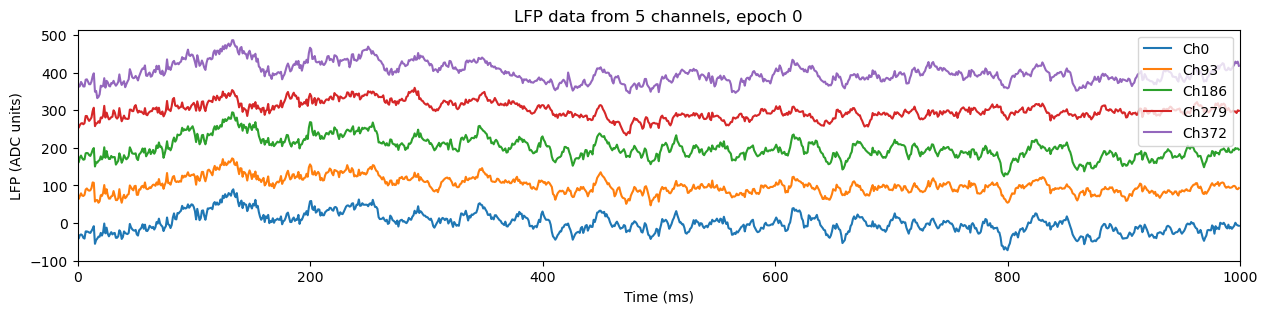

In [104]:
plt.figure(figsize=(15, 3))
plt.plot((data[0, :, 0::93]-np.mean(data[0, :, 0::93], axis=0))+np.array([0, 100, 200, 300, 400]))
plt.xlim(0, 1000)
plt.legend(['Ch0', 'Ch93', 'Ch186', 'Ch279', 'Ch372'])
plt.xlabel('Time (ms)')
plt.ylabel('LFP (ADC units)')
plt.title('LFP data from 5 channels, epoch 0')